In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
def load_images(image_folder, image_size):
    images = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(image_folder, filename)
            img = load_img(img_path, target_size=image_size, color_mode="grayscale")
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array)
    return np.array(images)

In [3]:
image_folder = 'Data/train/NORMAL_resized'
image_size = (224, 224)

In [4]:
images = load_images(image_folder, image_size)
images = np.reshape(images, (images.shape[0], 224, 224, 1))

In [5]:
images.shape

(1266, 224, 224, 1)

In [2]:
@keras.saving.register_keras_serializable()
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def build_autoencoder():
    input_img = Input(shape=(224, 224, 1))  # Input layer for grayscale images of size 224x224
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='leaky_relu', strides=(2, 2), padding='same')(input_img)  # Output: (112, 112, 32)
    x = Conv2D(64, (3, 3), activation='leaky_relu', strides=(2, 2), padding='same')(x)          # Output: (56, 56, 64)
    x = Conv2D(128, (3, 3), activation='leaky_relu', strides=(2, 2), padding='same')(x)         # Output: (28, 28, 128)
    encoded = Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(x)                   # Output: (28, 28, 128)

    # Decoder
    x = Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(encoded)                   # Output: (28, 28, 128)
    x = UpSampling2D((2, 2))(x)                                                           # Output: (56, 56, 128)
    x = Conv2D(64, (3, 3), activation='leaky_relu', padding='same')(x)                          # Output: (56, 56, 64)
    x = UpSampling2D((2, 2))(x)                                                           # Output: (112, 112, 64)
    x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same')(x)                          # Output: (112, 112, 32)
    x = UpSampling2D((2, 2))(x)                                                           # Output: (224, 224, 32)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)                  # Output: (224, 224, 1)

    # Model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001, weight_decay=1e-4), loss=ssim_loss)
    return autoencoder

In [3]:
model = build_autoencoder()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 480,385 (1.83 MB)

 Trainable params: 480,385 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.fit(images, images, epochs=25, batch_size=32, shuffle=True)

Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 896ms/step - loss: 0.5045
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 797ms/step - loss: 0.2588
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 760ms/step - loss: 0.2276
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 763ms/step - loss: 0.2113
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 761ms/step - loss: 0.1995
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 759ms/step - loss: 0.1859
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 760ms/step - loss: 0.1771
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 757ms/step - loss: 0.1707
Epoch 9/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 765ms/step - loss: 0.1659
Epoch 10/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 759ms/step - loss: 0.1590
Epoch 11/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 760ms/step - loss: 0.1574
Epoch 12/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 786ms/step - loss: 0.1511
Epoch 13/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 765ms/step - loss: 0.1500
Epoch 14/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 761ms/step - loss: 0.1464
Epoch 15/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 

In [10]:
import matplotlib.pyplot as plt

In [11]:
sample_img = images[102]

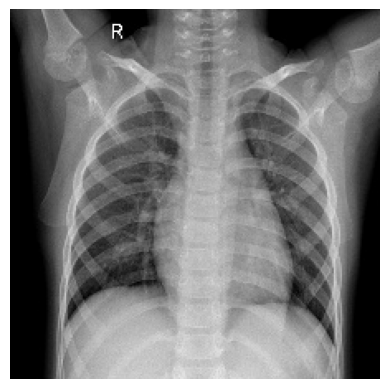

In [12]:
plt.imshow(sample_img, cmap='gray')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


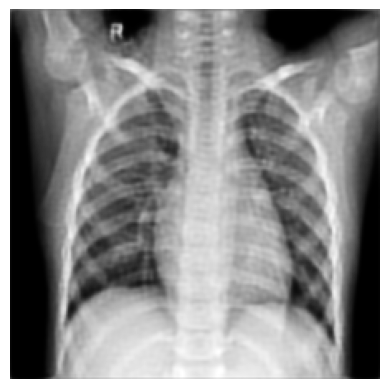

In [13]:
output_image = model.predict(np.expand_dims(sample_img, axis=0))
plt.imshow(output_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

In [40]:
def detect_anomalies(autoencoder, images):
    reconstructed_images = autoencoder.predict(images)
    reconstruction_error = np.mean(np.abs(reconstructed_images - images), axis=(1, 2, 3))
    return reconstruction_error

In [41]:
reconstruction_error = detect_anomalies(model, images)

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step


In [42]:
np.min(reconstruction_error)

np.float32(0.016567385)

In [43]:
np.max(reconstruction_error)

np.float32(0.034349665)

In [44]:
np.percentile(reconstruction_error,90)

np.float32(0.025433538)

In [45]:
check_images1 = load_images(r'Data\train\NOT_COVID_resized',(224,224))
check_images1.shape

(2028, 224, 224, 1)

In [46]:
check_images2 = load_images(r'Data\train\COVID19_resized',(224,224))
check_images2.shape

(460, 224, 224, 1)

In [47]:
final_images = np.concatenate((check_images2,check_images1),axis=0)
final_images.shape

(2488, 224, 224, 1)

In [48]:
reconstruction_error1 = detect_anomalies(model, final_images)

78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step


In [49]:
np.min(reconstruction_error1)

np.float32(0.012766166)

In [50]:
np.max(reconstruction_error1)

np.float32(0.04136106)

In [53]:
np.percentile(reconstruction_error1,90)

np.float32(0.024516962)